In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline

import metatensor 
from metatensor import Labels, TensorBlock, TensorMap
from metatensor import load, sort

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
    'gthszvmolopt': {
        6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],
        
        16: [[3,0,0], 
             [3,1,-1], [3,1,0], [3,1,1]],

        42: [[4,0,0], 
             [5,0,0], 
             [4,1,-1], [4,1,0], [4,1,1], 
             [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]}
}

# QC dataset

In [5]:
workdir = './'
START = 0 
STOP = 10
ORBS = 'sto-3g'
root = f'{workdir}/examples/data/periodic/deepH_graphene/wrap/'
data_dir = root
frames = read(f'{data_dir}/wrapped_deepH_graphene.xyz', slice(START, STOP))
rfock = [np.load(f"{data_dir}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [1,1,1]
dataset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [9]:
workdir = './'
root = f'{workdir}/examples/data/periodic/carbon_allotropes'
ORBS = 'sto-3g'
kmesh = np.loadtxt(f'{root}/kmesh.dat', dtype=int)
START = 20
STOP = 25

indices = kmesh[:,0][START:STOP]
kmesh = kmesh[:,1:][START:STOP].tolist()

frames = [read(f'{root}/{i}/cell_{i}.xyz') for i in indices]

for f in frames:
    f.wrap(center = (0,0,0), eps = 1e-30)
    # f.wrap(pretty_translation=True,eps=1e-20)

rfock=[np.load(f'{root}/{i}/realfock_{i}.npy', allow_pickle=True).item() for i in indices ]
rover=[np.load(f'{root}/{i}/realoverlap_{i}.npy', allow_pickle=True).item() for i in indices ]

In [10]:
dataset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=False,
                               dimension = 3,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

# Targets

In [11]:
cutoff = 8

In [13]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)

In [ ]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)
k_target_coupled_blocks = TMap_bloch_sums(target_coupled_blocks, phase, indices, kpts_idx, return_tensormap = True)

# Features

In [14]:
max_radial  = 8
max_angular = 6
atomic_gaussian_width = 0.3

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [15]:
features = compute_features(dataset, hypers_atom, hypers_pair = hypers_pair, lcut = 3)

cpu pair features
cpu single center features
cpu single center features


# ML Dataset/Dataloader

In [563]:
from metatensor.learn import Dataset, DataLoader, IndexedDataset
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts
import metatensor as mts
from mlelec.data.dataset import split_by_Aij, split_by_Aij_mts

In [565]:
split_by_Aij_mts(target_coupled_blocks)

RuntimeError: __init__() Expected a value of type 'List[__torch__.torch.classes.metatensor.Labels]' for argument 'components' but instead found type 'list'.
Position: 3
Value: [Labels(
    M
    0
)]
Declaration: __init__(__torch__.torch.classes.metatensor.TensorBlock _0, Tensor values, __torch__.torch.classes.metatensor.Labels samples, __torch__.torch.classes.metatensor.Labels[] components, __torch__.torch.classes.metatensor.Labels properties) -> NoneType _0
Cast error details: Tried to cast object to type __torch__.torch.classes.metatensor.Labels (of Python compilation unit at: 0) but object was missing attribute capsule

In [560]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = np.array([A])) for A in mts.unique_metadata(target_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = np.array([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features = mts.split(features, split_by_axis, grouped_labels)

KeyboardInterrupt: 

In [545]:
ml_data = IndexedDataset(descriptor = split_features, target = split_target, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

Split kspace targets

In [546]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = np.array([A])) for A in mts.unique_metadata(k_target_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_target_k = mts.split(k_target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = np.array([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features_k = mts.split(features, split_by_axis, grouped_labels)

In [547]:
ml_data_k = IndexedDataset(descriptor = split_features_k, target = split_target_k, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

# Train

In [548]:
from mlelec.metrics import L2_loss, L2_kspace_loss
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

In [553]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = features, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 128, 
                            nlayers = 2,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

nepoch = 1000

optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = 1e-3)) #, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.5, patience = 100, verbose=True))

In [554]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)

In [555]:
batch_size = 1
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))
dataloader_k = DataLoader(ml_data_k, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [557]:
16/3*1.45**2/(1e-5*100)*5.67e-8*300**3

17166.492

In [556]:
# %%timeit -n 1 -r 1

train_kspace = False
LOSS_LIST = []

nepoch = 100
for epoch in range(nepoch):

    if epoch >= 1000:
        train_kspace = True

    if not train_kspace:
        # Train against real space targets
        LOSS = 0
        lr = []
        for ib, batch in enumerate(dataloader):
            
            model.train(True)
            
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor, batch.target)
            
            # Compute the loss for each block
            all_losses, epoch_loss = L2_loss(pred, batch.target, loss_per_block = True)
    
            # Total loss
            epoch_loss = epoch_loss.item()
            LOSS += epoch_loss
    
            # Loop through submodels and backpropagate
            for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
                loss.backward(retain_graph = False)
                torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
                optimizers[ik].step()
                schedulers[ik].step(loss)
                lr.append(schedulers[ik].get_last_lr())
    else:
        # Train against k-space targets
    
        LOSS = 0
        lr = []
        for ib, batch in enumerate(dataloader_k):

            model.train(True)
    
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor)
            pred_kspace = TMap_bloch_sums(pred, phase, indices, kpts_idx, return_tensormap = True)
            
            # Compute the loss
            loss = L2_loss(pred_kspace, batch.target, norm = 2*np.prod(dataset.kmesh[0]))
    
            # Total loss 
            epoch_loss = loss.item()
            LOSS += epoch_loss
                   
            loss.backward(retain_graph = True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            for ik, key in enumerate(model.model):
                optimizers[ik].step()
                schedulers[ik].step(epoch_loss/len(model.model))
                lr.append(schedulers[ik].get_last_lr())

    if epoch >= 0: #% 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        LOSS_LIST.append(LOSS)
        print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, avg lr = {np.mean(lr)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss 11530.2510092855, avg lr = 0.0010000000000000002
Epoch       1, train loss 7580.3090475239, avg lr = 0.0010000000000000002
Epoch       2, train loss 5552.4979475927, avg lr = 0.0010000000000000002
Epoch       3, train loss 3763.3769321438, avg lr = 0.0010000000000000002
Epoch       4, train loss 2448.4908343881, avg lr = 0.0010000000000000002
Epoch       5, train loss 1987.8065645943, avg lr = 0.0010000000000000002
Epoch       6, train loss 1666.8587666231, avg lr = 0.0010000000000000002
Epoch       7, train loss 1612.8572440769, avg lr = 0.0010000000000000002
Epoch       8, train loss 1000.0819467077, avg lr = 0.0010000000000000002
Epoch       9, train loss  112.8189782143, avg lr = 0.0010000000000000002
Epoch      10, train loss  504.5451281099, avg lr = 0.0010000000000000002
Epoch      11, train loss   62.7767195192, avg lr = 0.0010000000000000002
Epoch      12, train loss  231.5838399113, avg lr = 0.0010000000000000002
Epoch      13, train loss  208.782769

In [248]:
for (k, b1), b2 in zip(model().items(), target_coupled_blocks.blocks()):
    
    # print(k.values,torch.abs((b1.values-b2.values)/b2.values.std()).mean().item(), b2.values.norm().item(), b1.values.norm().item(), b2.values.std().item())
    print(k.values,torch.norm(b1.values-b2.values).item(), (torch.norm(b1.values-b2.values)/torch.norm(b2.values)).item())

[-1  6  1  0  6  2  0  0] 0.004239009844360395 3.225461508421634
[-1  6  1  0  6  2  1  1] 2.763699504639493 0.26476040298980924
[-1  6  2  0  6  2  1  1] 1.4648108965980395 0.23896006432465194
[-1  6  2  1  6  2  1  1] 0.2745105154690156 0.3362838534700777
[0 6 1 0 6 1 0 0] 0.8413568715903756 0.008646469818762026
[0 6 1 0 6 2 0 0] 0.2816123032638789 0.010519238054456596
[0 6 1 0 6 2 1 1] 0.016164074612878908 1.107596709653799
[0 6 2 0 6 2 0 0] 0.32056433344185253 0.032386121413119404
[0 6 2 0 6 2 1 1] 0.0763899349732039 0.19424094401894412
[0 6 2 1 6 2 1 0] 0.08502651688401347 0.028419030371375827
[0 6 2 1 6 2 1 2] 0.07573189074466695 0.051794911637676765
[1 6 1 0 6 1 0 0] 0.014840724051500378 39.16303015559414
[1 6 1 0 6 2 0 0] 1.4676744834863051 0.23451526535405412
[1 6 1 0 6 2 1 1] 0.00957162960281307 4.214663288393323
[1 6 2 0 6 2 0 0] 1.7432176523285356 0.25341590328439134
[1 6 2 0 6 2 1 1] 0.1239250889870734 0.30178068267267727
[1 6 2 1 6 2 1 0] 0.29109619142961185 0.28523897732

In [245]:
for b in mts.subtract(model(), target_coupled_blocks).blocks():
    print(torch.abs(b.values).mean())

tensor(2.2933e-05, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0400, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(9.4167e-05, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(1.7644e-05, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)


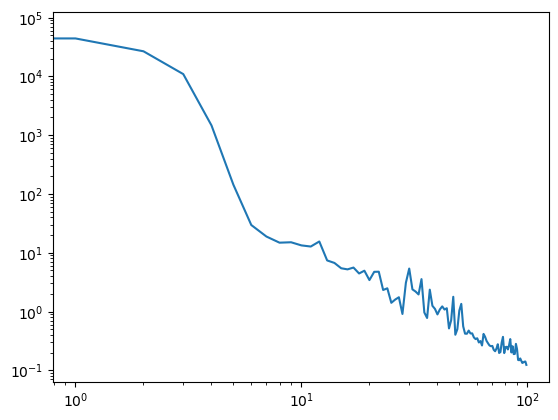

In [49]:
plt.loglog(LOSS_LIST)

In [86]:
# %%timeit -n 1 -r 1

train_kspace = False
LOSS_LIST = []

nepoch = 100
for epoch in range(nepoch):

    if epoch >= 100:
        train_kspace = True

    if not train_kspace:
        # Train against real space targets
        LOSS = 0
        lr = []
        for ib, batch in enumerate(dataloader):
            
            model.train(True)
            
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor, batch.target)
            pred_kspace = TMap_bloch_sums(pred, phase, indices, kpts_idx, return_tensormap = True)
            targ_kspace = TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True)
            # Compute the loss
            loss = L2_loss(pred_kspace, targ_kspace, norm = 2*np.prod(dataset.kmesh[0]))
    
            # Total loss 
            epoch_loss = loss.item()
            LOSS += epoch_loss
                   
            loss.backward(retain_graph = True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            for ik, key in enumerate(model.model):
                optimizers[ik].step()
                schedulers[ik].step(epoch_loss/len(model.model))
                lr.append(schedulers[ik].get_last_lr())

    if epoch >= 0: #% 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        LOSS_LIST.append(LOSS)
        print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}, avg lr = {np.mean(lr)}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss 5496.0295864783, avg lr = 0.001
Epoch       1, train loss 4717.5638229153, avg lr = 0.001
Epoch       2, train loss 4331.9782585512, avg lr = 0.001
Epoch       3, train loss 4051.0466575342, avg lr = 0.001
Epoch       4, train loss 3812.3163783132, avg lr = 0.001
Epoch       5, train loss 3591.1969913513, avg lr = 0.001
Epoch       6, train loss 3384.1479565959, avg lr = 0.001
Epoch       7, train loss 3186.6593445958, avg lr = 0.001
Epoch       8, train loss 2993.8159987875, avg lr = 0.001
Epoch       9, train loss 2801.4397752083, avg lr = 0.001
Epoch      10, train loss 2606.4725344421, avg lr = 0.001
Epoch      11, train loss 2410.6770568707, avg lr = 0.001
Epoch      12, train loss 2214.6587748237, avg lr = 0.001
Epoch      13, train loss 2017.9251521149, avg lr = 0.001
Epoch      14, train loss 1820.0987684940, avg lr = 0.001
Epoch      15, train loss 1621.0406197192, avg lr = 0.001
Epoch      16, train loss 1420.6902653086, avg lr = 0.001
Epoch      17,

Traceback (most recent call last):
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_382400/640400133.py", line 25, in <module>
    targ_kspace = TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pegolo/Software/mlelec/src/mlelec/utils/pbc_utils.py", line None, in TMap_bloch_sums
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-p

In [16]:
checkpoint = torch.load('/home/pegolo/Software/mlelec/examples/data/periodic/carbon_allotropes/model_6700epochs_10structures.ckpt')

In [17]:
from mlelec.models.linear import LinearModelPeriodic
allo_model = LinearModelPeriodic(twocfeat = features, 
                                     target_blocks = target_coupled_blocks,
                                     frames = dataset.structures, orbitals = dataset.basis, 
                                     device = device,
                                     bias = True,
                                     nhidden = 128, 
                                     nlayers = 2,
                                     activation = 'SiLU',
                                     apply_norm = True)
allo_model = allo_model.double()

In [18]:
allo_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
pred_from_allo = allo_model.predict(features, target_coupled_blocks)

In [21]:
from mlelec.metrics import L2_loss
L2_loss(pred_from_allo, target_coupled_blocks)

tensor(44.3026, grad_fn=<AddBackward0>)

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

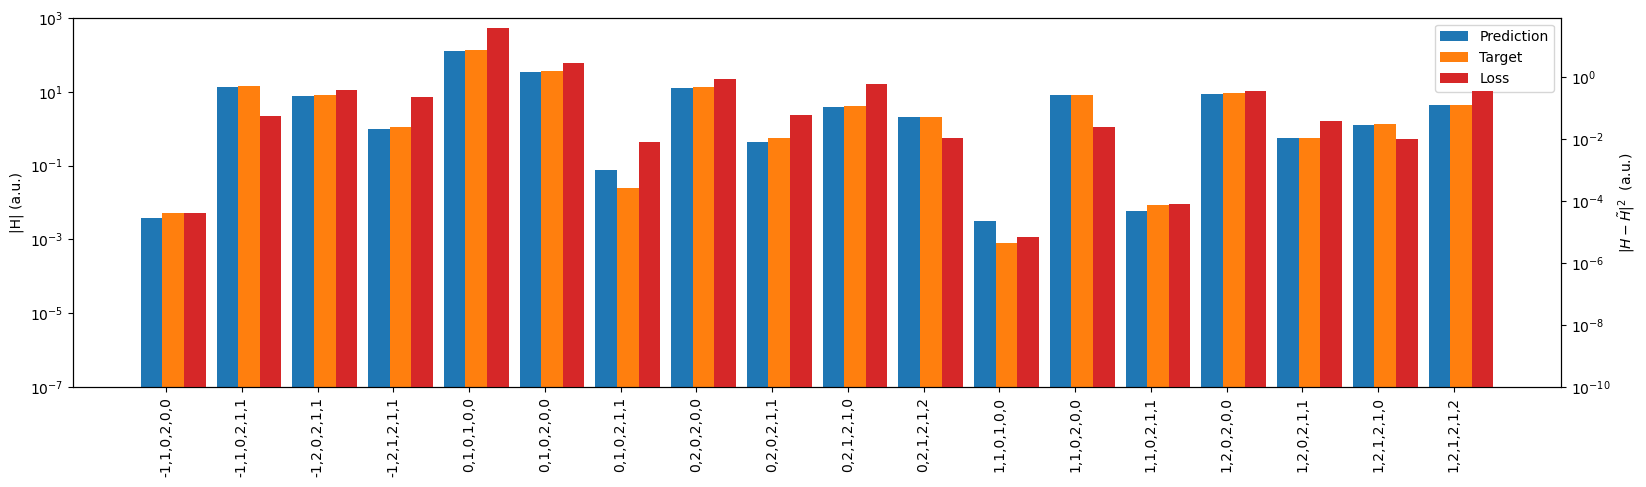

In [23]:
# pred = allo_model()
plot_block_errors(target_coupled_blocks, pred_from_allo, plot_loss=True)

In [24]:
recon_HT = blocks_to_matrix(pred_from_allo, dataset)

In [25]:
recon_Hk = dataset.bloch_sum(recon_HT)

In [26]:
cutoff_overlaps = blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff, target='overlap'), dataset)

In [28]:
cutoff_target = blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff), dataset)

In [27]:
recon_Sk = dataset.bloch_sum(cutoff_overlaps)

In [29]:
cutoff_Hk = dataset.bloch_sum(cutoff_target)

In [30]:
from scipy.linalg import eigvalsh
eigvals_target = {}
eigvals_pred = {}
for A in range(len(dataset)):
    eigvals_target[A] = []
    eigvals_pred[A] = []
    for ik in range(len(dataset.fock_kspace[A])):
        # eigvals_target[A].append(eigvalsh(dataset.fock_kspace[A][ik].numpy(), dataset.overlap_kspace[A][ik].numpy()))
        eigvals_target[A].append(eigvalsh(cutoff_Hk[A][ik].detach().numpy(), recon_Sk[A][ik].detach().numpy()))
        eigvals_pred[A].append(eigvalsh(recon_Hk[A][ik].detach().numpy(), recon_Sk[A][ik].detach().numpy()))

In [294]:
view(dataset.structures)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

Text(0, 0.5, 'Predict. eigval (a.u.)')

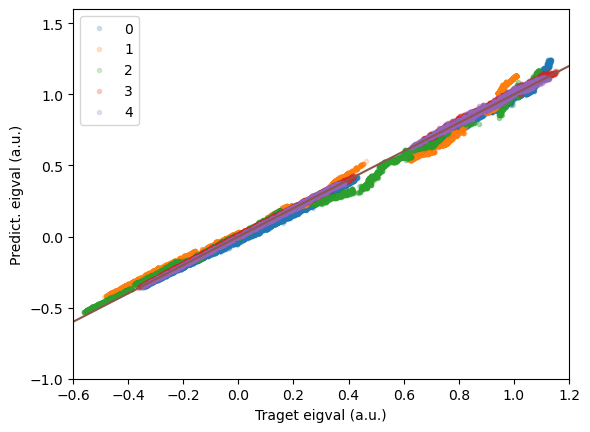

In [38]:
for A in eigvals_target:
    # if A != 2:
        plt.plot(np.concatenate(eigvals_target[A]), np.concatenate(eigvals_pred[A]), '.', alpha = 0.2, label = A)
plt.plot([-11,2], [-11,2])
# plt.plot([-1,2], [-1,2])
plt.legend()
# plt.xlim(-9.78,-9.7)
# plt.ylim(-9.78,-9.7)
plt.xlim(-0.6,1.2)
plt.ylim(-1,1.6)
plt.xlabel('Traget eigval (a.u.)')
plt.ylabel('Predict. eigval (a.u.)')

In [161]:
sum(np.concatenate(eigvals_target)<-8)

720

[]

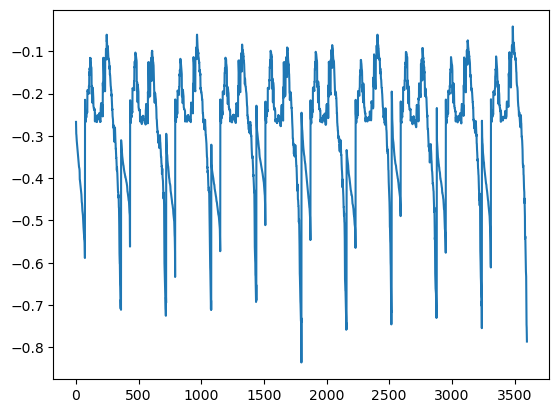

In [162]:
plt.plot(np.concatenate(eigvals_target) - np.concatenate(eigvals_pred))
plt.plot()

In [147]:
view(frames)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

# Meh

In [59]:
split_features, split_target = split_by_Aij(target_coupled_blocks, features = features)

## Using tensormaps

In [65]:
split_features, split_target = split_by_Aij_mts(target_coupled_blocks, features = features)

In [66]:
ml_data = IndexedDataset(descriptor = list(split_features.values()), target = list(split_target.values()), sample_id = list(split_target.keys()))

In [111]:
batch_size = 20
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = True, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [92]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)

In [112]:
kmap = []
for batch in dataloader:
    kmap.append(TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True))

## Debug

In [487]:
from mlelec.utils.plot_utils import block_matrix_norm, matrix_norm

In [498]:
rij, Hij = block_matrix_norm(target_coupled_blocks, dataset)

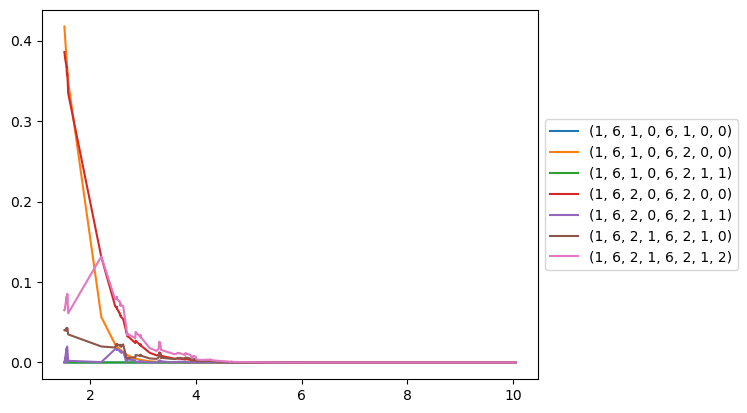

In [499]:
for k in rij:
    if k[0] == 1:
        x = np.array(rij[k])
        y = np.array(Hij[k])
        plt.plot(x[x.argsort()], y[x.argsort()], '-', label = k)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))